<a href="https://colab.research.google.com/github/sayan0506/Deep-Neural-Network-with-Pytorch-/blob/main/Building_Deep_Learning_Model_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the MNIST classification problem using a Deep Neural Network

In [237]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.optim as optimizer
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn

In [238]:
# loading the dataset
dataset = MNIST(root = '/content/Dataset', download = True, train= True, transform=ToTensor())

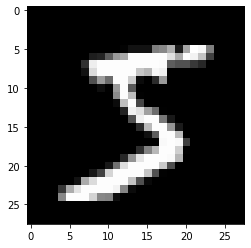

Label:  5


In [239]:
plt.imshow(dataset[0][0].reshape(28,28), cmap = 'gray')
plt.show()
print('Label: ', dataset[0][1])

# Training and Validation set

In [240]:
val_pct = 0.2
train_ds, validation_ds = random_split(dataset, lengths=[int(len(dataset)*(1-val_pct)), int(len(dataset)*val_pct)])

In [241]:
print(len(train_ds), len(validation_ds))

48000 12000


 Note:
* num_workers (int, optional): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
*  pin_memory (bool, optional): If True, the data loader will copy Tensors into CUDA pinned memory before returning them.  If your data elements are a custom type, or your collate_fn returns a batch that is a custom type, see the example below.

Normally what happens, we load dataset in CPU, and send or push data to GPU while training, but, we can increase the transfer from host to GPU during training by enabling pin_memory = True, which copies the tensors to CUDA pinned memory, which increases speed and reduces the data loading time

In [242]:
batch_s = 128
# implementing the dataloader for creating the batches
train_dl = DataLoader(train_ds, batch_size = batch_s, shuffle = True, num_workers=4, pin_memory = True)
validation_dl = DataLoader(validation_ds, batch_size=batch_s, shuffle = True, num_workers = 4, pin_memory=True)


images shape:  torch.Size([128, 1, 28, 28])


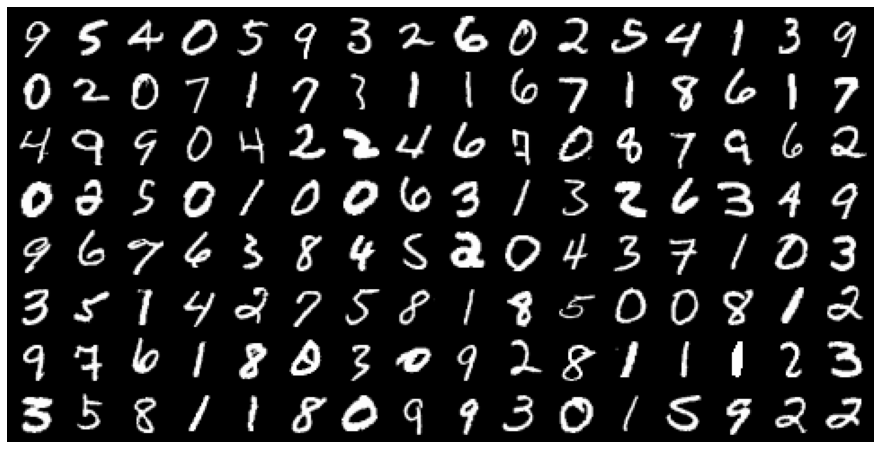

In [243]:
for images, _ in train_dl:
  print('images shape: ', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  # nrow (int, optional): Number of images displayed in each row of the grid.
  plt.imshow(make_grid(images, nrow = 16).permute((1,2,0)))
  break

In [244]:
# this is why make_grid is used for rearranging the shapes
make_grid(images, nrow = 16).permute((1,2,0)).shape

torch.Size([242, 482, 3])

In [245]:
# defining the accuracy
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

# Building the Multi-Layer-Perceptron model

In [246]:
# building the model
class MnistModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    # flatten the image tensors to pass to a fully-connected hidden layer
    xb = xb.view(xb.shape[0], -1) 
    # get intermediate output using hidden layer
    out = self.linear1(xb)
    # Apply activation function
    out = F.relu(out)
    # get predictions using output layer
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [247]:
images.shape

torch.Size([128, 1, 28, 28])

In [248]:
# when we want to reshape it to (shape[0], -1)
# shape[0] = 128
# -1 implies the index before zero, but only two coordinates are here, so 
# it creates shape = (m, (28*28))
# here m = 128
# we use tensor.view() to reshape the tensor

images.view(images.shape[0],-1).shape

torch.Size([128, 784])

In [249]:
input_size = 784
# considering 32 nodes in the hidden layer
hidden_size = 32 
num_classes = 10

In [250]:
model = MnistModel(input_size, hidden_size, out_size=num_classes)

In [251]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [252]:
model.parameters
# structure of the model
# Input -> Hidden(ReLU activation) -> Output layer

<bound method Module.parameters of MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)>

# Using GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. You can use GPUs for free on Kaggle kernels or Google Colab, or rent GPU-powered machines on services like Google Cloud Platform, Amazon Web Services or Paperspace.


In [253]:
# we can check whether GPU is available and the required NVIDIA drivers are installed or not
# For Deep Learning NVIDIA is the only option
# if the GPU is not Nvidia, then torch.cuda.is_available() would return False
torch.cuda.is_available()

True

In [254]:
# define a helper function to ensure that our code uses GPU if available, else it will use CPU as default
def get_default_device():
  """Pick GPU if available else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [255]:
device = get_default_device()
# we created device object or allocating device for training
print(device)

cuda


In [256]:
# let's define a helper function that can move data and model to a chosen device

def to_device(data, device):
  # Move tensor(s) to chosen device
  if isinstance(data, (list, tuple)):
    # checks whether data is the instance of list or tuple
    # or we can say whether data is a list or tuple
    # thst is what the isinstance does
    return [to_device(x, device) for x in data]
    # here we used recusion
    # to ensure whether 
  return data.to(device, non_blocking = True)  

In [257]:
for images, labels in train_dl:
  print(images.shape)
  print(images.device)
  images = to_device(images, device)
  print(images.device)
  break

# we see the images are copied from CPU to cuda

torch.Size([128, 1, 28, 28])
cpu
cuda:0


**Define DeviceDataLoader to load existing data in the dataloader to the device**

In [258]:
# now the thing is we will not load the entire dataset to cuda
# we will load batches to cuda using dataloader, so for that functionality 
# to help the dataloader to load data to the assigned device(torch.device('cuda) here)
# we have to define another helper function

class DeviceDataLoader():
  # wrap a dataloader to move data to device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # yield a batch of data after moving it to device
    # we use yield instead of return as, yield continues the execution where it was left-off
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # returning number of batches
    return len(self.dl)


In [259]:
train_loader = DeviceDataLoader(train_dl, device)
validation_loader = DeviceDataLoader(validation_dl, device)

In [260]:
for xb, yb in train_loader:
  print(xb.device)
  print(yb.device)
  break

cuda:0
cuda:0


# Training the model


In [261]:
# training the model
def evaluate(model, validation_loader):
  outputs = [model.validation_step(batch) for batch in validation_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, opt_func = optimizer.SGD):
  history = []
  opt = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
    # validation phase after all epochs
    result = evaluate(model, validation_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [262]:
model = MnistModel(input_size, hidden_size, out_size=num_classes)
to_device(model, device)
# loaing the model to device

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [263]:
history = fit(10, 0.001, model, train_loader, validation_loader)

Epoch [0], val_loss: 2.2312, val_acc: 0.2390
Epoch [1], val_loss: 2.1548, val_acc: 0.3969
Epoch [2], val_loss: 2.0701, val_acc: 0.5319
Epoch [3], val_loss: 1.9761, val_acc: 0.6293
Epoch [4], val_loss: 1.8723, val_acc: 0.6795
Epoch [5], val_loss: 1.7597, val_acc: 0.7030
Epoch [6], val_loss: 1.6413, val_acc: 0.7129
Epoch [7], val_loss: 1.5221, val_acc: 0.7221
Epoch [8], val_loss: 1.4087, val_acc: 0.7350
Epoch [9], val_loss: 1.3037, val_acc: 0.7463


In [267]:
accuracies = [result['val_loss'] for result in history]

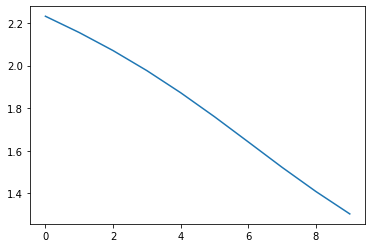

In [269]:
plt.plot(accuracies)